# Semestrální projekt 3

In [1]:
library(eurostat);
library(dplyr);
library(e1071);
library(vioplot);
library(ggplot2);
library(corrplot);
library(olsrr);
library(car);
library(lmtest);
library(MASS);
library(gridExtra);

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: sm

Package 'sm', version 2.2-5.7: type help(sm) for summary information

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


corrplot 0.92 loaded


Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


Warning message:
“package ‘MASS’ was built under R version 4.3.0”

Attaching package: ‘MASS’


The following object is masked from ‘package:olsrr’:

    cement


The following object is masked from ‘p

## Načtení a úprava dat

In [2]:
data <- get_eurostat("nama_10_gdp")

Table nama_10_gdp cached at /tmp/Rtmpirj3yu/eurostat/nama_10_gdp_date_code_FF.rds



In [3]:
year <- 2011 + ((26 + nchar("Beneš")) * 47) %% 11 + 1
year

[1] 2017

In [4]:
data <- data %>% 
    filter(time == "2017-01-01" & unit == "CP_MEUR", na_item == "B1GQ") %>%
    dplyr::select(c(geo, values))

data %>% arrange(desc(values)) %>% head(10)

geo,values
<chr>,<dbl>
EU28,15434623
EU15,14105752
EU27_2020,13074833
EA20,11274139
EA,11224153
EA19,11224153
EA12,10971128
DE,3267160
UK,2359790


Ponecháme pouze záznamy jednotlivých zemí.

In [5]:
geo_out <- c("EU28", "EU15", "EU27_2020", "EA20", "EA", "EA19", "EA12")
data <- data %>% filter(!geo %in% geo_out)

data %>% arrange(desc(values)) %>% head(10)

geo,values
<chr>,<dbl>
DE,3267160.0
UK,2359789.9
FR,2297242.0
IT,1736592.8
ES,1162492.0
TR,760497.1
NL,738146.0
CH,615776.3
SE,480025.5


In [6]:
data$values %>% is.na %>% sum %>% cat("Počet chybějících hodnot:", .)

Počet chybějících hodnot: 0

## Úloha 1

### Popis dat a rozdělení hodnot

Data obsahují informace o HDP evropských zemí (dle výpočtu v tržních cenách). Data se vážou k roku 2017.

Hodnoty HDP jsou v našem případě vyjádřeny v milionech eur.

Zatím data neobsahují žádnou jinou informaci o zemích.

Prozkoumáme rozdělení těchto hodnot.

In [7]:
data %>% summary

     geo                values       
 Length:39          Min.   :   4299  
 Class :character   1st Qu.:  25409  
 Mode  :character   Median : 176903  
                    Mean   : 443143  
                    3rd Qu.: 455411  
                    Max.   :3267160  

Máme data o 39 evropských zemích.

Z našich dat vyplývá, že nejnižší hodnota HDP je 4 299, zatímco nejvyšší dosahuje 3 267 160. Takový velký rozdíl je zajímavý, ale nepřekvapující, protože HDP závisí mimo jiné na velikosti země a v Evropě se nachází i mikrostáty.

Průměrná hodnota je 443 143, kdežto median 176 903. To je poměrně velký rozdíl. Znamená to, že v datech se vyskytuje několik zemí s vysokým HDP, které posunují průměr, zatímco většina zemí má HDP nižší. To je opět zřejmě způsobeno výraznou nevyvážeností ve velikostech a životních úrovních států v Evropě.

Třetí kvartil je blízký průměru. To znamená, že přibližně tři čtvrtiny zemí mají podprůměrné HDP.

Skok mezi třetím kvartilem a maximální hodnotou je obrovský. Nejspíše se poblíž maxima jedná o odlehlé hodnoty.

In [8]:
data$values %>% skewness %>% round(2) %>% cat("Výběrová šikmost:", .)

Výběrová šikmost: 2.31

Šikmost doprava je velká. To potvrzuje naše předchozí pozorování, že nižší hodnoty HDP jsou četnější než vyšší.

In [9]:
data$values %>% kurtosis %>% round(2) %>% cat("Výběrová špičatost:", .)

Výběrová špičatost: 4.74

Špičatost je kladná, dokonce větší než 3, které má normální rozdělení. To znamená, že hodnoty nejspíše nabývají poměrně špičatého vrcholu. Tento vrchol můžeme zanedlouho prozkoumat na vizualizaci odhadu distribuce.

In [10]:
data$values %>% sd %>% round(2) %>% cat("Směrodatná odchylka:", .)

Směrodatná odchylka: 744257

Směrodatná odchylka je poměrně vysoká. K tomu opět přispívají odlehlé hodnoty.

Odhad rozdělení HDP evropských zemí nám může dát histogram těchto hodnot.

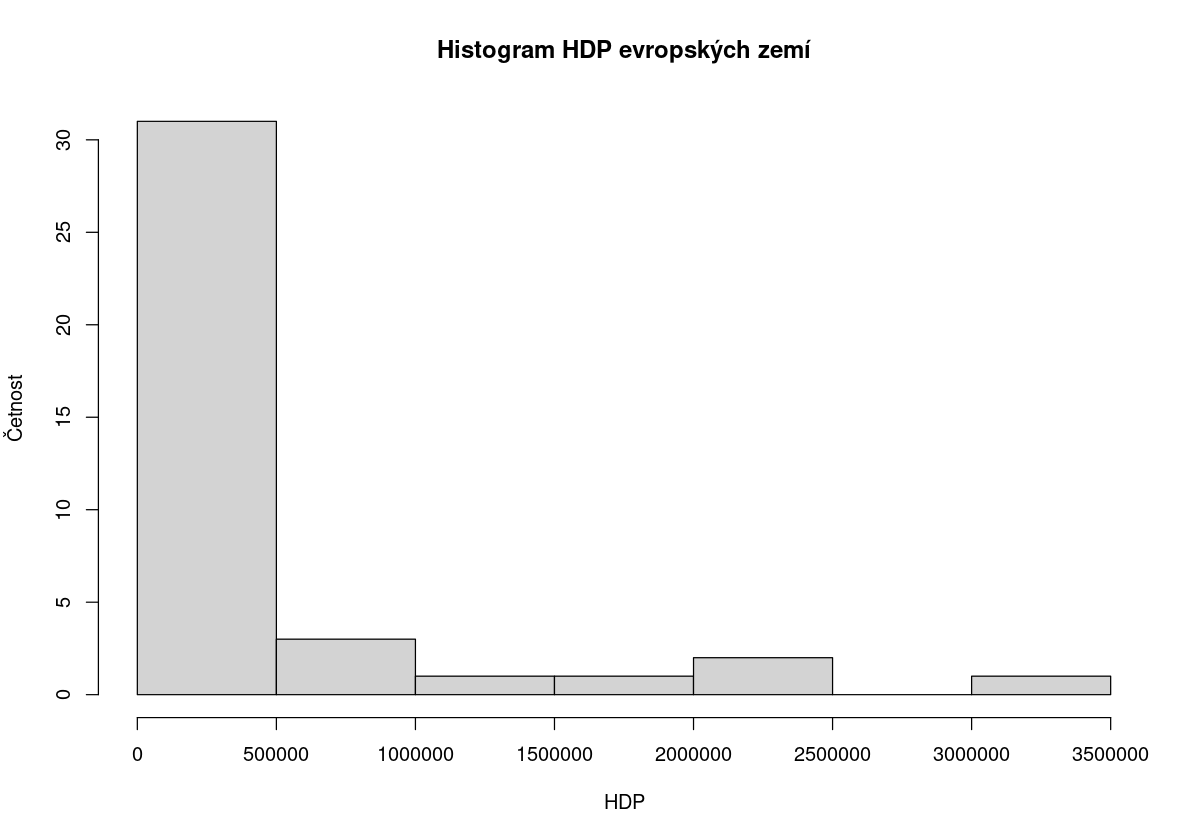

In [11]:
options(repr.plot.width=10, repr.plot.height=7, scipen=5)

data$values %>% hist(main="Histogram HDP evropských zemí", xlab="HDP", ylab="Četnost")

Můžeme opět pozorovat vysokou koncentraci nízkých hodnot.

Pro další náhled vykreslíme krabicový graf.

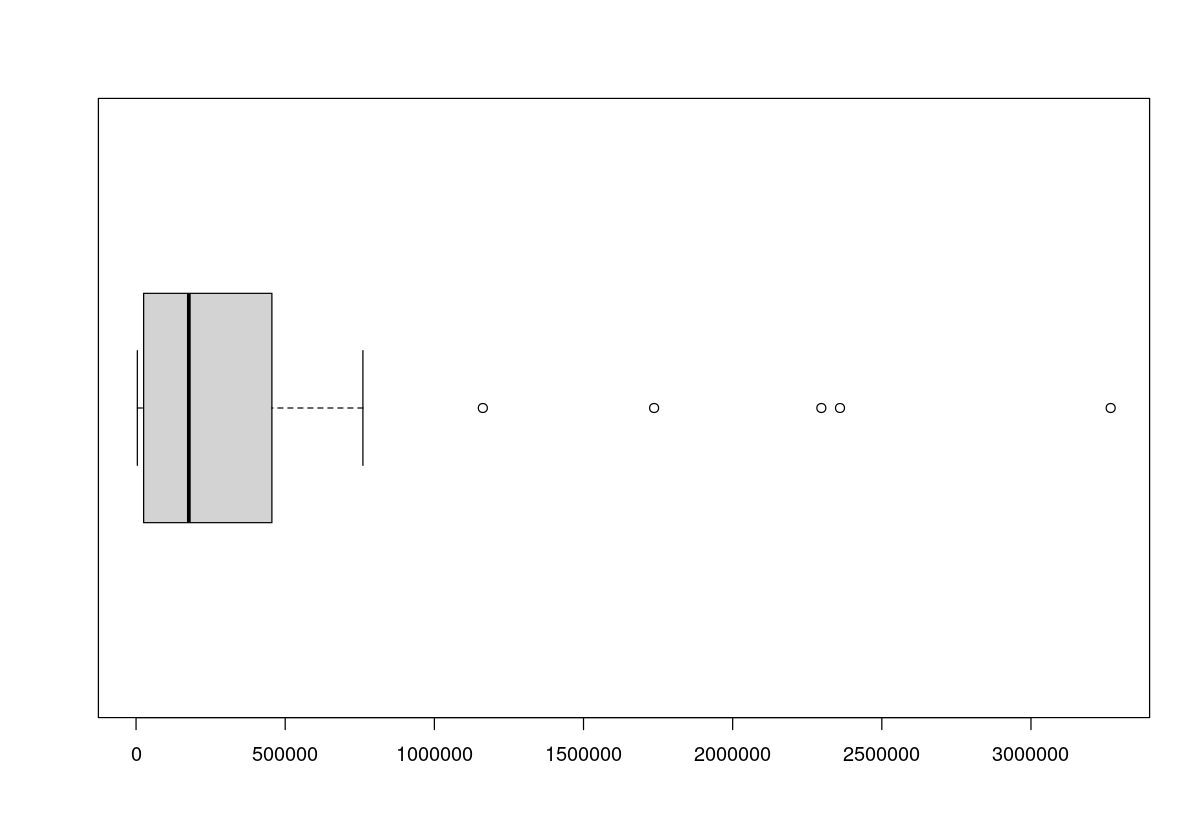

In [12]:
data$values %>% boxplot(horizontal = TRUE)

Na této vizualizaci jde vidět několik odlehlých hodnot.

### Které údaje o zemích by mohly mít na HDP vliv

Protože se jedná o celkové HDP, rozhodně bude silně ovlivněno velikostí země. Zde bude nejspíše nejlepší indikátor počet obyvatel. Často se totiž z důvodu srovnání zemí na stejnou úrověň uvádí hodnota HDP per capita, kterou získáme podělením HDP počtem obyvatel. Z toho však vyplývá, že nelze úplně nejlépe popsat HDP pouze počtem obyvatel. Geografická rozloha by také mohla mít vliv, nejen že často souvisí s počtem obyvatel, ale také má vliv například na přírodní zdroje, infrastrukturu a obchod dané země. Toto mimo jiné také souvisí s geografickou polohou.

Dalším faktorem ovlivňujícím HDP je jistě politika a ekonomický systém země. Zde je zejména důležitá stabilita systému, přístup k investicím a podnikatelům nebo daňová politika země. Veškeré další politické aspekty však můžou hrát nemalou roli.

V neposlední řadě mohou HDP ovlivnit i sociální faktory, jako například míra chudoby, rovnoměrnost příjmů, vzdělání nebo kultura.

Mohli bychom jmenovat dále. Faktorů je nespočet. HDP je totiž komplexní proměnná, která závisí nejen na aktuálních údajích, ale i na historii země.

## Úloha 2

### Volba regresorů

V našem případě nás zajímají údaje vyjádřitelné určitou hodnotou. Existuje však mnoho faktorů, které se převádějí do hodnot těžko. Například kulturu země bychom se mohli pokusit vyjádřit mnoha kategorickými a spojitými proměnnými, avšak pořád bychom ji dostatečně nepopsali.

Je třeba vybrat takové údaje, které mohou být popsány hodnotou a mají potenciální vliv na HDP.

In [13]:
data <- data %>% rename(GDP = values)

#### Počet obyvatel

Očividným regresorem je počet obyvatel, což je hodnota, která dává HDP do kontextu velikosti země.

https://ec.europa.eu/eurostat/databrowser/view/MIGR_IMM8/default/table?lang=en&category=migr.migr_cit.migr_immi

In [14]:
population <- get_eurostat("demo_pjan")

Table demo_pjan cached at /tmp/Rtmpirj3yu/eurostat/demo_pjan_date_code_FF.rds



In [15]:
population <- population %>%
    filter(time == "2017-01-01" & sex == "T" & age == "TOTAL") %>%
    dplyr::select(c("geo", "values")) %>%
    rename(population = values)

data <- data %>% left_join(population, by = "geo")

#### Průměrný příjem

Se znalostí počtu obyvatel je navíc třeba popsat HDP již zanořené do kontextu velikosti země. V našem případě hledáme regresor, který by dobře popisoval HDP per capita. Takovým může být třeba [Equivalised disposable income](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Equivalised_disposable_income) (dále průměrný příjem).

https://ec.europa.eu/eurostat/databrowser/view/ILC_DI03$DV_405/default/table?lang=en&category=qol.qol_mlc.qol_mlc_i

In [16]:
income <- get_eurostat("ilc_di03")

Table ilc_di03 cached at /tmp/Rtmpirj3yu/eurostat/ilc_di03_date_code_FF.rds



In [17]:
income <- income %>%
    filter(time == "2017-01-01" & age == "TOTAL" & indic_il == "MEI_E" & sex == "T" & unit == "EUR") %>%
    dplyr::select(c("geo", "values")) %>%
    rename(income = values)

data <- data %>% left_join(income, by = "geo")

#### Počet imigrantů

Kdo by nechtěl žít v prosperující zemi. Když emigrant hledá nový domov, poohlíží se mimo jiné po zemích s lepší ekonomickou prosperitou, která souvisí s celkovou kvalitou života. Navíc příchozí migranti mohou svojí aktivitou zvyšovat HDP dané země.
 Proto údaj o počtu imigrantů zaznamenaných v daném roce může být vypovídající o HDP.
https://ec.europa.eu/eurostat/databrowser/view/MIGR_IMM8/default/table?lang=en&category=migr.migr_cit.migr_immi

In [18]:
immigration <- get_eurostat("migr_imm8")

Table migr_imm8 cached at /tmp/Rtmpirj3yu/eurostat/migr_imm8_date_code_FF.rds



In [19]:
immigration <- immigration %>%
    filter(age == "TOTAL" & agedef == "COMPLET" & sex == "T" & time == "2017-01-01") %>%
    dplyr::select(c("geo", "values")) %>%
    rename(immigration = values)

data <- data %>% left_join(immigration, by = "geo")

#### Země východního bloku

Potenciálně vypovídající proměnnou může být informace o tom, jestli země byla (z většiny svého území) součástí východního bloku. Tyto země totiž byly v nedávné historii politicky a ekonomicky oddělené od zbytku světa, což mohlo ovlivnit jejich nynější HDP. 

https://en.wikipedia.org/wiki/Eastern_Bloc

In [20]:
eastern_bloc <- read.csv("eastern_bloc.csv", header = TRUE, stringsAsFactors = TRUE)

In [21]:
data <- data %>% left_join(eastern_bloc, by = "geo")

### Chybějící hodnoty

Pojďme se podívat, u kolika zemí máme chybějící hodnoty:

In [22]:
colSums(is.na(data))
# https://stackoverflow.com/questions/4862178/remove-rows-with-all-or-some-nas-missing-values-in-data-frame
missing <- data[!complete.cases(data),]
missing

geo          GDP   population       income  immigration eastern_bloc 
           0            0            1            3            5            0

geo,GDP,population,income,immigration,eastern_bloc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
AL,11559.0,2876591,2143,NA,yes
BA,16260.5,NA,NA,NA,yes
LI,5734.6,37810,NA,645,no
RS,39235.3,7040272,2915,NA,yes
TR,760497.1,79814871,5434,NA,no
XK,6356.5,1783531,NA,NA,yes


In [23]:
cat("Missing values in", nrow(missing), "out of", nrow(data), "rows.")

Missing values in 6 out of 39 rows.

Pro skoro $\frac{1}{8}$ zemí nám chybí záznamy, data se nám však nepodařilo na jiných zdrojích dohledat, proto se chybějících hodnot zbavíme.

Podle [ISO_3166](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) vidíme, že se jedná o Albánii, Bosnu a Hercegovinu, Lichtenštejnsko, Srbsko, Turecko a Kosovo.

In [24]:
data <- data[!(data$geo %in% missing$geo),]

### Odebrání příznaku geo

Jelikož nebudeme přidávat další regresory, nepotřebujeme již znát jména příslušných zemí.

In [25]:
data <- subset(data, select = -c(geo))

### Vztah regresorů k HDP

Nyní pojďme prozkoumat, zda zvolené regresory HDP opravdu vysvětlují. Začneme s numerickými regresory.

#### Numerické regresory

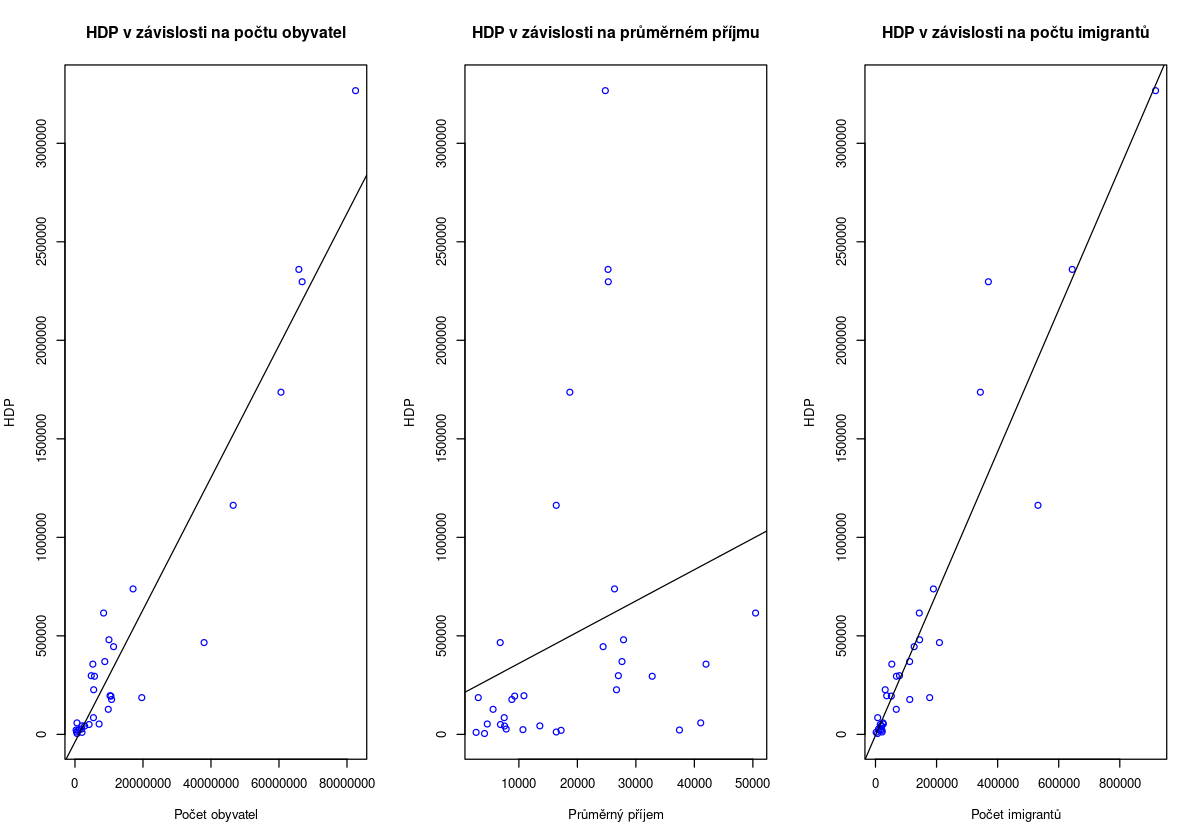

In [26]:
par(mfrow=c(1,3))
# population
plot(data$GDP~data$population, col="blue", main="HDP v závislosti na počtu obyvatel", xlab="Počet obyvatel", ylab="HDP")
abline(lm(data$GDP~data$population))
# income
plot(data$GDP~data$income, col="blue", main="HDP v závislosti na průměrném příjmu", xlab="Průměrný příjem", ylab="HDP")
abline(lm(data$GDP~data$income))
# immigration
plot(data$GDP~data$immigration, col="blue", main="HDP v závislosti na počtu imigrantů", xlab="Počet imigrantů", ylab="HDP")
abline(lm(data$GDP~data$immigration))

Všechny zvolené regresory nejspíš pozitivně korelují s HDP. U průměrného příjmu vidíme outliery, kterými nejspíš budou mikrostáty, či státy s velkým počtem obyvatel.

O korelaci se ujištěme pomocí testu korelačních koeficientů - můžeme použít buď Pearsonův, nebo Spearmanův. Pearsonův test vyžaduje normalitu, nejdříve tedy otestujme tu. Použijeme Shapirův-Wilkův test:

- $H_0$: $X_1,\ldots, X_n$ je výběr z normálního rozdělení
- $H_A$: neplatí $H_0$

In [27]:
shapiro.test(data$GDP)


	Shapiro-Wilk normality test

data:  data$GDP
W = 0.64273, p-value = 0.00000009844


Normalitu HDP skutečně na standardní hladině spolehlivosti zamítáme, spočteme tedy Spearmanův pořadový korelační koeficient a budeme testovat jeho nulovost:

$\rho_S$ = Spearmanův pořadový korelační koeficient

- $H_0: \rho_S = 0$
- $H_A: \rho_S \ne 0$

In [28]:
cor(data$GDP, data$population, method="spearman") %>% round(2) %>% cat("Spearmanův korelační koeficient pro HDP a počet obyvatel:", ., "\n")
cor(data$GDP, data$income, method="spearman") %>% round(2) %>% cat("Spearmanův korelační koeficient pro HDP a hodnotu průměrného příjmu:", ., "\n")
cor(data$GDP, data$immigration, method="spearman") %>% round(2) %>% cat("Spearmanův korelační koeficient pro HDP a počet imigrantů:", ., "\n")
cor.test(data$GDP, data$population, method="spearman")
cor.test(data$GDP, data$income, method="spearman")
cor.test(data$GDP, data$immigration, method="spearman")

Spearmanův korelační koeficient pro HDP a počet obyvatel: 0.86 
Spearmanův korelační koeficient pro HDP a hodnotu průměrného příjmu: 0.48 
Spearmanův korelační koeficient pro HDP a počet imigrantů: 0.92 



	Spearman's rank correlation rho

data:  data$GDP and data$population
S = 822, p-value = 0.0000001537
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8626337 



	Spearman's rank correlation rho

data:  data$GDP and data$income
S = 3132, p-value = 0.005514
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4766043 



	Spearman's rank correlation rho

data:  data$GDP and data$immigration
S = 492, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9177807 


Pro všechny numerické regresory na standardní hladině spolehlivosti zamítáme nulovou korelaci.

Nyní se račme podívat, jak dobrým ukazatelem HDP je příslušnost k zemím východního bloku.

#### Kategorické regresory

 no yes 
 20  13 


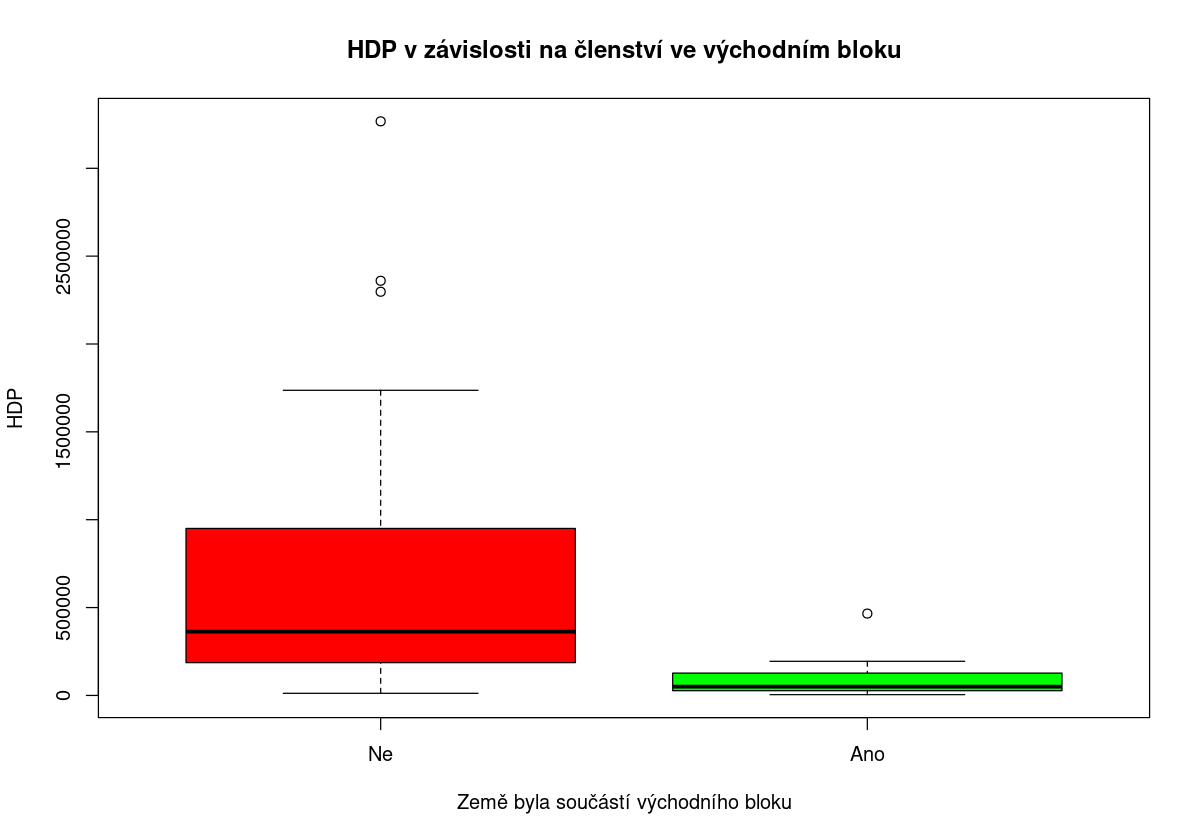

In [29]:
boxplot(
    data$GDP~data$eastern_bloc,
    col=c("red","green"),
    main="HDP v závislosti na členství ve východním bloku",
    xlab="Země byla součástí východního bloku",
    ylab="HDP",
    names=c("Ne", "Ano")
)

print(summary(data$eastern_bloc))

Vidíme, že máme 20 zemí, které nebyly součástí východního bloku a 13 zemí, které byly součástí východního bloku. Země východního bloku dosahují menšího HDP.

Jelikož jsme v předchozí části zamítli normalitu HDP, použijeme znovu Spearmanův korelační koeficient a budeme testovat jeho nulovost.

In [30]:
cor(data$GDP, data$eastern_bloc == "yes", method="spearman") %>% round(2) %>% cat("Spearmanův korelační koeficient pro HDP a členství ve východním bloku:", ., "\n")
cor.test(data$GDP, as.numeric(data$eastern_bloc == "yes"), method="spearman")

Spearmanův korelační koeficient pro HDP a členství ve východním bloku: -0.53 


Warning message in cor.test.default(data$GDP, as.numeric(data$eastern_bloc == "yes"), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  data$GDP and as.numeric(data$eastern_bloc == "yes")
S = 9179.9, p-value = 0.001368
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.5340764 


Nulovost korelačního koeficientu taktéž na standardní hladině spolehlivosti pro členství ve východním bloku zamítáme.

### Vlastnosti regresorů

Přesvědčeni, že jsme vybrali regresory, které nějakým způsobem souvisí s HDP, už jsme. Proto pojďme jednotlivé regresory blíže prozkoumat.

#### Počet obyvatel

Nejprve si pro snazší interpretovatelnost převeďme počet obyvatel na miliony.

In [31]:
population <- data$population / 10^6
summary(population)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3383  2.0737  7.1019 16.0027 11.3517 82.5216 

Vidíme, že počet obyvatel se pohybuje v rozmezí 0.34 milionu - 82.52 milionů. Očekávali bychom, že rozdělení bude podobné, jelikož právě velikost země je prvním intuitivním ukazatelem HDP. Tuto hypotézu podporuje fakt, že hodnota průměru značně převyšuje medián, ba dokonce třetí kvartil. Můžeme tedy čekat pár outlierů s vysokým počtem obyvatel.

Dalším zajímavým pozorováním je, že 75 % zemí má méně než 11.35 milionů obyvatel.

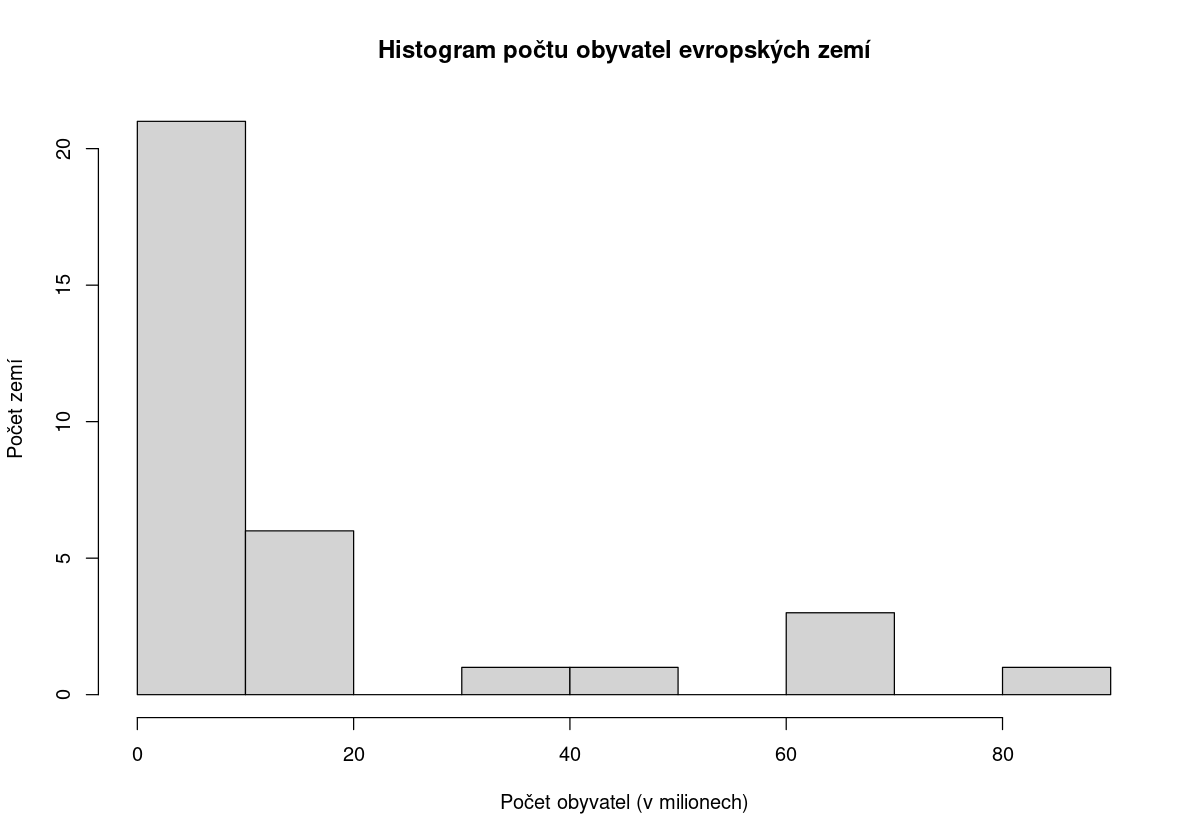

In [32]:
hist(population, main="Histogram počtu obyvatel evropských zemí", xlab="Počet obyvatel (v milionech)", ylab="Počet zemí")

Pozorujeme, že počet obyvatel je opravdu rozdělen podobně jako HDP.

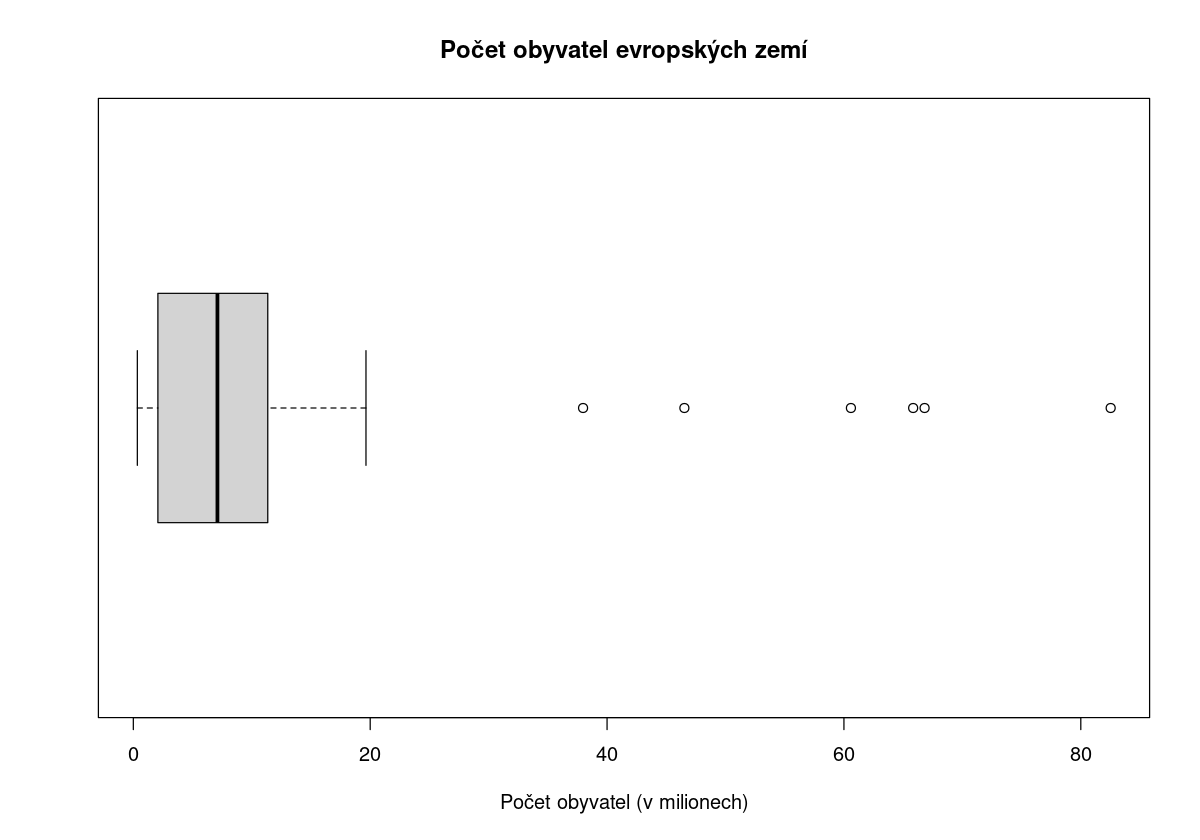

In [33]:
boxplot(population, horizontal = TRUE, main="Počet obyvatel evropských zemí", xlab="Počet obyvatel (v milionech)")

Opět pozorujeme několik odlehlých hodnot, které jsou příčinou vychýlení průměru.

#### Průměrný příjem

Podle [dokumentace](https://ec.europa.eu/eurostat/cache/metadata/en/ilc_esms.htm) data obsahují [Equivalised disposable income](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Equivalised_disposable_income), což je suma příjmů v rámci jedné domácnosti bez všech výdajů, která je váženě rozdělena mezi jednotlivé členy domácnosti. Tato metrika by nám tedy měla dát informaci o HDP per capita. Jelikož však jde o tak zamotanou metriku, budeme raději opatrnější v interpretaci jejích hodnot.

In [34]:
income <- data$income
summary(income)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2691    7555   16390   18715   26689   50461 

Vidíme, že průměrný příjem se pohybuje mezi 2 700 a 50 000 eur. Průměr je lehce vyšší než medián, můžeme tedy očekávat pár outlierů s vysokou hodnotou.

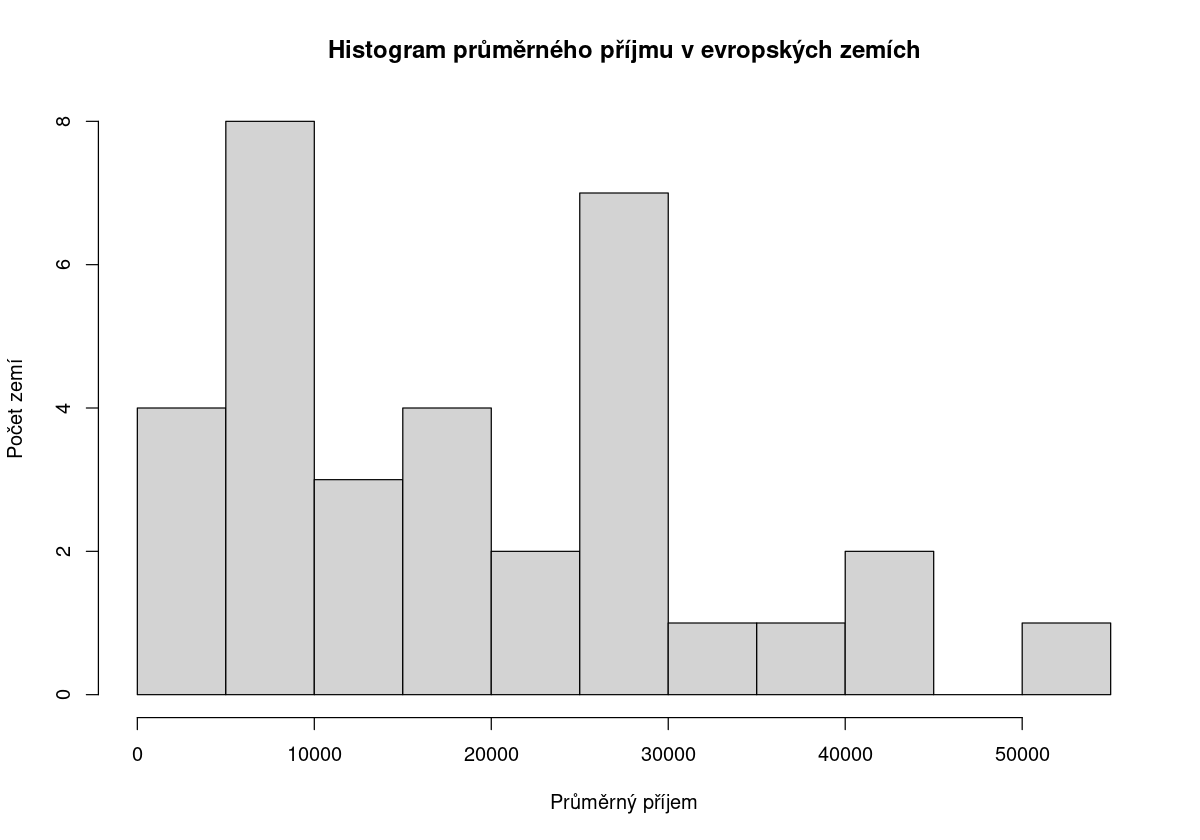

In [35]:
hist(income, main="Histogram průměrného příjmu v evropských zemích", xlab="Průměrný příjem", ylab="Počet zemí")

Pozorujeme 2 "peaky" - jeden mezi 5 000 a 10 000, a druhý mezi 25 000 a 30 000. 

#### Počet imigrantů

In [36]:
immigrantion <- data$immigration
summary(immigrantion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2064   20368   53351  139806  144489  917109 

U počtu imigrantů pozorujeme obrovské rozpětí - nejméně 2 000 a nejvíce 900 000. Vyšší hodnoty budou však nejspíše outliery, jelikož je průměr značně vychýlen od mediánu směrem k vyšším hodnotám.
Očekávali bychom tedy rozdělení podobné jako u HDP a počtu obyvatel.

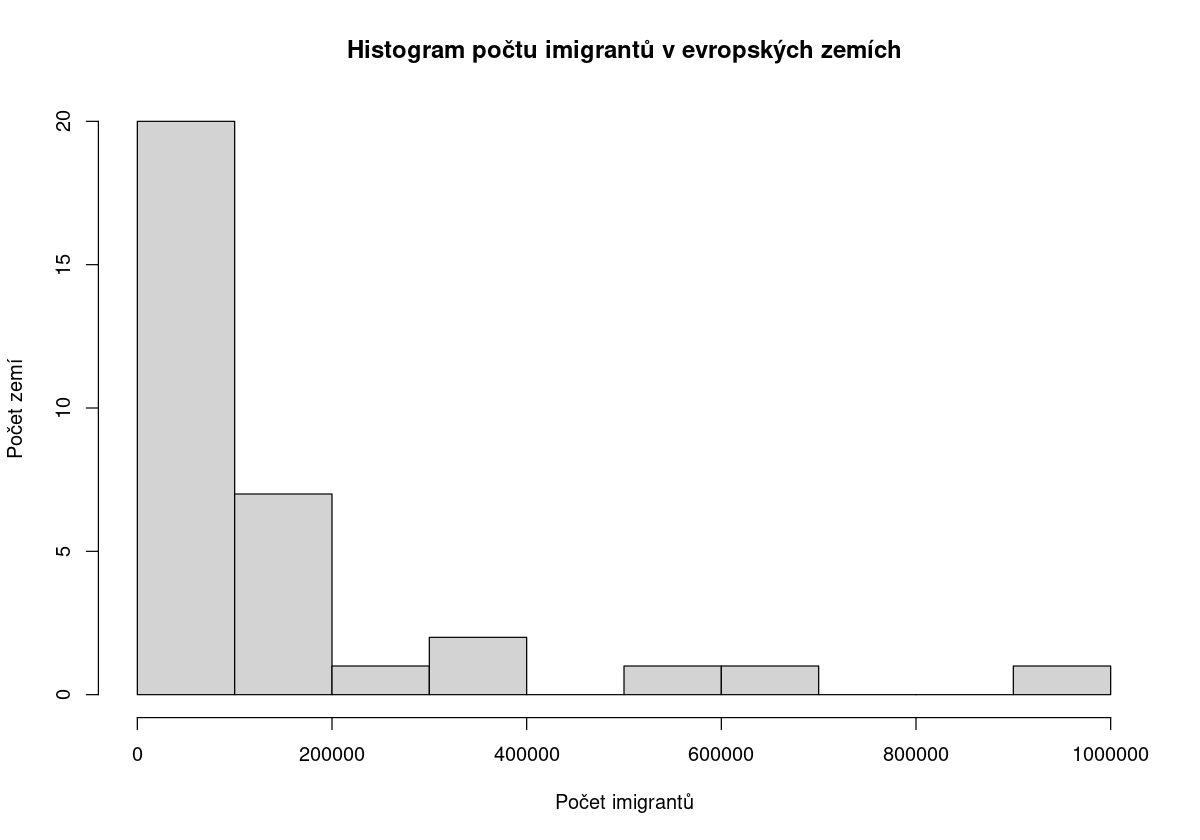

In [37]:
hist(immigrantion, main="Histogram počtu imigrantů v evropských zemích", xlab="Počet imigrantů", ylab="Počet zemí")

Skutečně je počet imigrantů rozdělen velmi podobně jako HDP a počet obyvatel.

#### Země východního bloku

In [38]:
cat("Počet hodnot u jednotlivých skupin:", table(data$eastern_bloc), "\n")

Počet hodnot u jednotlivých skupin: 20 13 


Vidíme, že 20 zemí nebylo součástí východního bloku, zatímco 13 zemí bylo, obě kategorie jsou tedy solidně zastoupeny.

### Závislosti mezi regresory

Nejprve vybereme z dat pouze regresory a převedeme kategorické proměnné na numerické.

In [39]:
regressors <- subset(data, select=-c(GDP))
regressors$eastern_bloc <- as.numeric(regressors$eastern_bloc == "yes")

Jelikož budeme znovu používat testy nulovosti korelačních koeficientů, otestujme nejdříve normalitu, pro numerické proměnné použijeme znovu Shapirův-Wilkův test, pro kategorickou proměnnou použijeme Kolmogorův-Smirnovův test (kvůli duplicitním hodnotám, se kterými má Shapirův-Wilkův test problém), v obou případech testujeme:

- $H_0$: $X_1,\ldots, X_n$ je výběr z normálního rozdělení
- $H_A$: neplatí $H_0$

In [40]:
shapiro.test(data$population)
shapiro.test(data$income)
shapiro.test(data$immigration)
ks.test(regressors$eastern_bloc, "pnorm", mean(regressors$eastern_bloc), sd(regressors$eastern_bloc))


	Shapiro-Wilk normality test

data:  data$population
W = 0.67635, p-value = 0.0000002916



	Shapiro-Wilk normality test

data:  data$income
W = 0.9207, p-value = 0.01916



	Shapiro-Wilk normality test

data:  data$immigration
W = 0.66533, p-value = 0.0000002028


Warning message in ks.test(regressors$eastern_bloc, "pnorm", mean(regressors$eastern_bloc), :
“ties should not be present for the Kolmogorov-Smirnov test”



	One-sample Kolmogorov-Smirnov test

data:  regressors$eastern_bloc
D = 0.39244, p-value = 0.00007703
alternative hypothesis: two-sided


Pro všechny regresory normalitu na standardní hladině spolehlivosti zamítáme, pro korelační analýzu tedy použijeme znovu Spearmanův korelační koeficient. Nejprve si vykresleme korelační matici regresorů:

,population,income,immigration,eastern_bloc
population,1.00,0.02,0.88,-0.24
income,0.02,1.00,0.35,-0.82
immigration,0.88,0.35,1.00,-0.52
eastern_bloc,-0.24,-0.82,-0.52,1.00


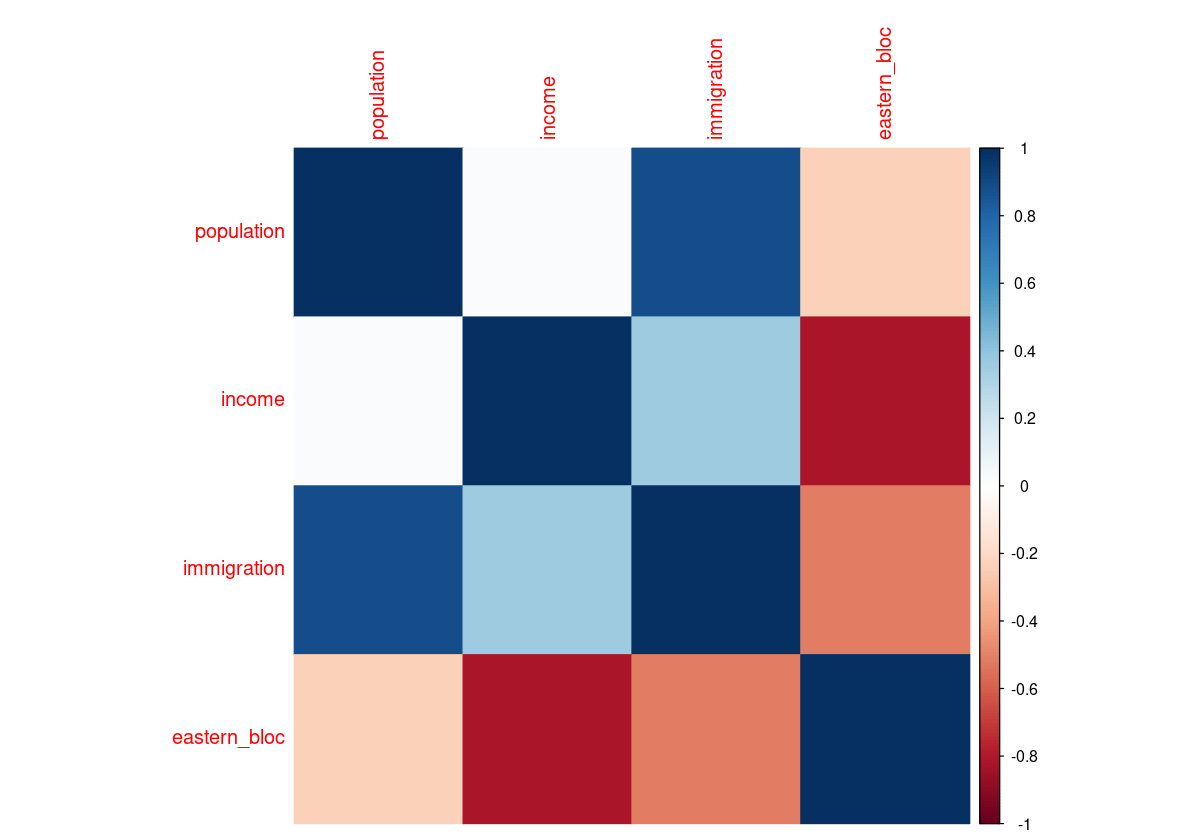

In [41]:
cors <- cor(regressors, method="spearman") %>% round(2)
cors
corrplot(cors, method="color")

Pozorujeme silnou pozitivní korelaci mezi Počtem obyvatel a Počtem imigrantů. Mezi Průměrným příjmem a Členstvím ve východním bloku pozorujeme silnou negativní korelaci. Dále spolu méně významně koreluje negativně Počet imigrantů a Členství ve východním bloku.

Otestujme nulovost pozorovaných korelačních koeficientů:

In [42]:
cor.test(regressors$population, regressors$income, method="spearman")
cor.test(regressors$population, regressors$immigration, method="spearman") #!
cor.test(regressors$population, regressors$eastern_bloc, method="spearman")
cor.test(regressors$income, regressors$immigration, method="spearman") #!
cor.test(regressors$income, regressors$eastern_bloc, method="spearman") #!
cor.test(regressors$immigration, regressors$eastern_bloc, method="spearman") #!


	Spearman's rank correlation rho

data:  regressors$population and regressors$income
S = 5836, p-value = 0.8914
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.02473262 



	Spearman's rank correlation rho

data:  regressors$population and regressors$immigration
S = 712, p-value = 0.00000007079
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.881016 


Warning message in cor.test.default(regressors$population, regressors$eastern_bloc, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  regressors$population and regressors$eastern_bloc
S = 7426.1, p-value = 0.1767
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2409857 



	Spearman's rank correlation rho

data:  regressors$income and regressors$immigration
S = 3886, p-value = 0.04611
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.3506016 


Warning message in cor.test.default(regressors$income, regressors$eastern_bloc, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  regressors$income and regressors$eastern_bloc
S = 10895, p-value = 0.000000004991
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.8206539 


Warning message in cor.test.default(regressors$immigration, regressors$eastern_bloc, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  regressors$immigration and regressors$eastern_bloc
S = 9102, p-value = 0.001876
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.5210501 


U pozorovaných hodnot skutečně nulovost zamítáme, navíc zamítáme však i nulovost korelačního koeficientu mezi Průměrným příjmem a Počtem imigrantů.

Závěrem tedy můžeme říct, že počet imigrantů se jeví jako nejproblémovější regresor, který by nejspíš bylo vhodné zahodit.

## Úloha 3

#### Lineární regresní model - zkoumání závislosti HDP na všech regresorech

Začneme vytvořením modelu, který je lineární kombinací všech příznaků.

Takový model má rezidua v rozsahu ~-520000 - ~280000 a medián ~31000.

Koeficient determinace vyšel 0.9553.

F-test významnosti modelu zamítá nezávislost regresandu na regresorech.

Odhady koeficientů pro tento lineární model jsou:
* 1, intercept = -229218 | odchylka = 120709 | t-test nezamítá nulovost koeficientu
* 2, pupulace = 0.023706 | odchylka = 0.004014 | t-test zamítá nulovost koeficientu
* 3, příjem = 10.050970 | odchylka = 3.910333 | t-test zamítá nulovost koeficientu
* 4, imigrace = 1.104321 | odchylka = 0.442527 | t-test zamítá nulovost koeficientu
* 5, východní blok = 14292 | odchylka = 104303 | t-test nezamítá nulovost koeficientu

In [43]:
fit_lin_all <- lm(GDP ~ population + income + immigrantion + eastern_bloc, data=data)
predicts <- predict(fit_lin_all, interval="prediction")
df_lin_all <- cbind(data, predicts)
summary(fit_lin_all)

Warning message in predict.lm(fit_lin_all, interval = "prediction"):
“predictions on current data refer to _future_ responses
”



Call:
lm(formula = GDP ~ population + income + immigrantion + eastern_bloc, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-519135  -20117   31120   80591  280327 

Coefficients:
                      Estimate     Std. Error t value   Pr(>|t|)    
(Intercept)     -229218.300382  120709.505171  -1.899     0.0679 .  
population            0.023706       0.004014   5.905 0.00000236 ***
income               10.050970       3.910333   2.570     0.0158 *  
immigrantion          1.104321       0.442527   2.495     0.0187 *  
eastern_blocyes   14292.855390  104303.719703   0.137     0.8920    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 178400 on 28 degrees of freedom
Multiple R-squared:  0.9553,	Adjusted R-squared:  0.9489 
F-statistic: 149.6 on 4 and 28 DF,  p-value: < 2.2e-16


#### Praktická interpretace hodnot odhadů regresních koeficientů

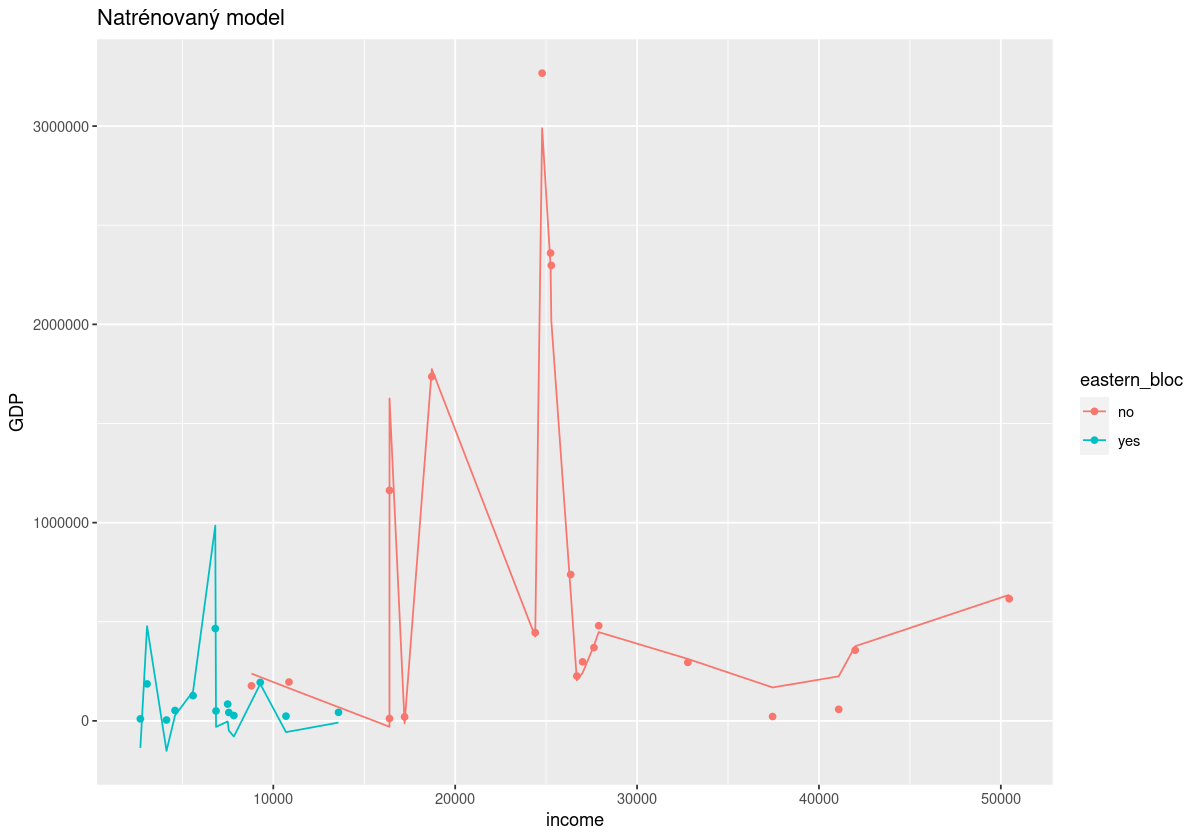

In [44]:
# regresní závislost graficky
ggplot(df_lin_all, aes(x=income, y=GDP, color=eastern_bloc)) +
    geom_point() +
    geom_line(aes(y=fit)) +
    labs(title="Natrénovaný model")

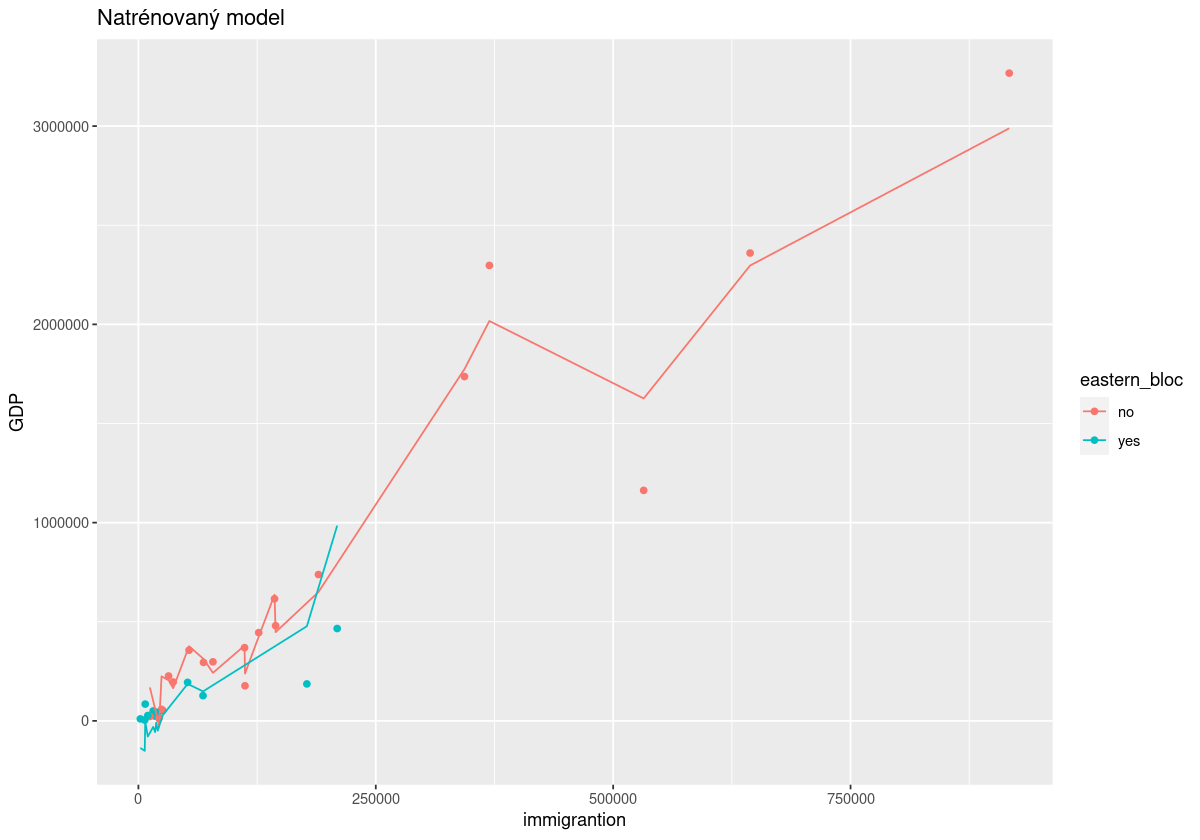

In [45]:
# regresní závislost graficky
ggplot(df_lin_all, aes(x=immigrantion, y=GDP, color=eastern_bloc)) +
    geom_point() +
    geom_line(aes(y=fit)) +
    labs(title="Natrénovaný model")

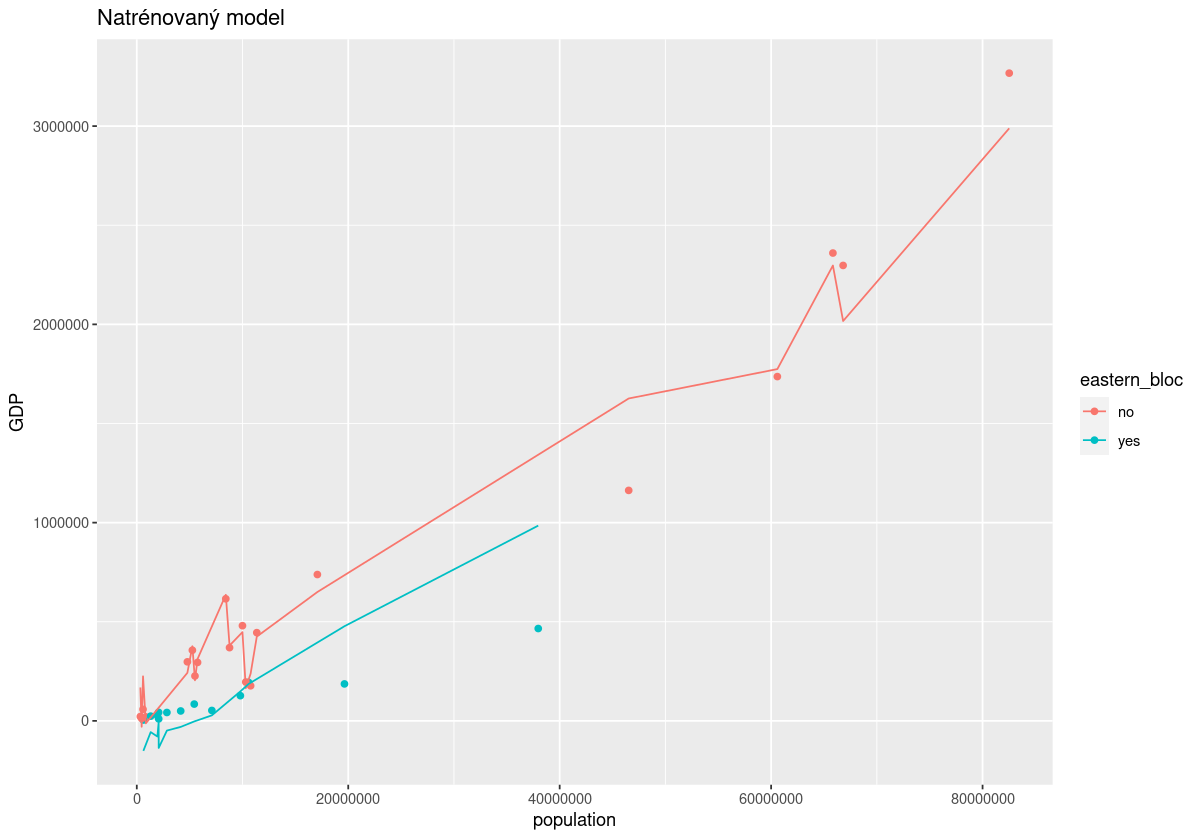

In [46]:
# regresní závislost graficky
ggplot(df_lin_all, aes(x=population, y=GDP, color=eastern_bloc)) +
    geom_point() +
    geom_line(aes(y=fit)) +
    labs(title="Natrénovaný model")

#### Zhodnocení kvality modelu

Průměr reziduí by se u dobrého modelu měl pohybovat kolem 0, což v našem případě není na první pohled z grafu reziduí pravda.

Dále můžeme pozorovat, že pro HDP nad ~500000 se predikce výrazně zhoršují, což je pravděpodobně způsobeno nedostatkem bodů a velkým rozsahem hodnot HDP.

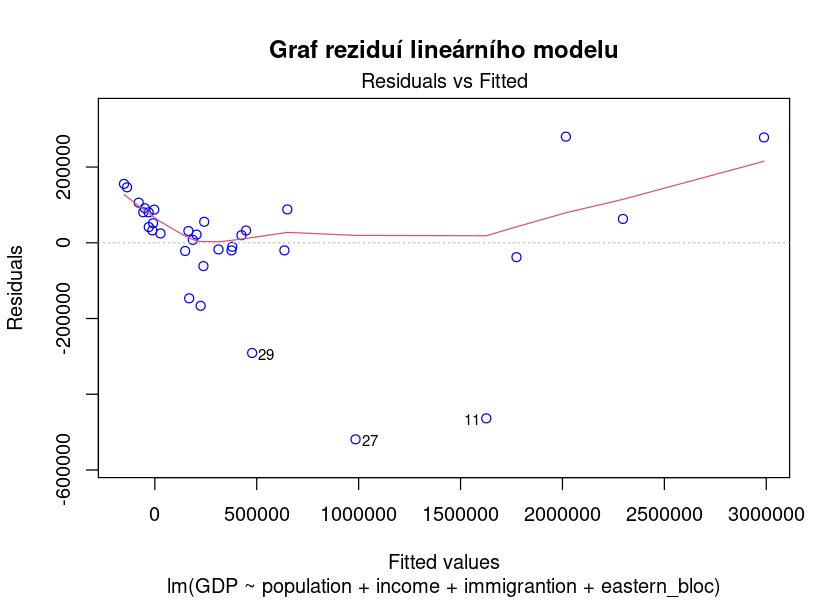

In [47]:
# reziduální rozptyl, průměr očekáván 0
options(repr.plot.width=7, repr.plot.height=5, scipen=5)
p1 <- plot(fit_lin_all, which=1, col=c("blue"), main="Graf reziduí lineárního modelu")

Koeficient korelace mezi predikcemi a reálnými hodnotami regresandun naznačuje solidní lineární závislost regresandu a predikce.

In [48]:
ols_test_correlation(fit_lin_all)

[1] 0.9067935

Kvalita modelu se dá hodnotit i normalitou reziduí.

Na základě všech vyzkoušených testů normalitu zamítáme, to mluví v neprospěch modelu.

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.8339         0.0002 
Kolmogorov-Smirnov        0.2362         0.0419 
Cramer-von Mises          3.3636         0.0000 
Anderson-Darling          2.0659         0.0000 
-----------------------------------------------

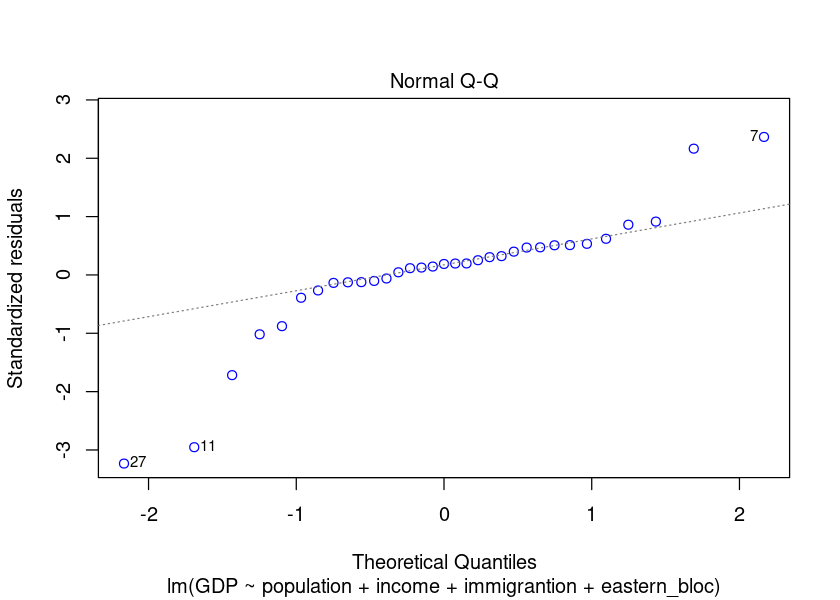

In [49]:
# test normality reziduí
options(repr.plot.width=7, repr.plot.height=5, scipen=5)
plot(fit_lin_all, which=2, col=c("blue"))
ols_test_normality(fit_lin_all)

Na následujícím grafu Cookovy vzdálenost můžeme pozorovat vliv jednotlivých bodů na predikce a identifikovat tak outliery. 4 body mají opravdu výrazně větší vliv na predikci, než ostatní.

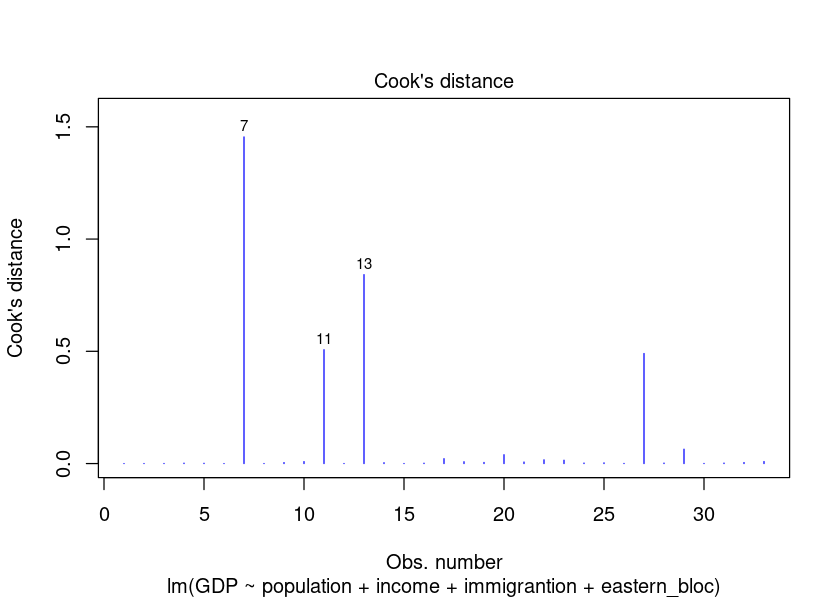

In [50]:
# Cookova vzdálenost (vliv jednotlivých pozorování - detekce outlierů)
options(repr.plot.width=7, repr.plot.height=5, scipen=5)
p <- plot(fit_lin_all, which=4, col=c("blue"))

#### Zkoumání multikolinearity

Teď se podíváme na problém multikolinearity, tedy korelace mezi příznaky.

Na korelační matici příznaků pozorujeme silnou korelaci mezi populací a imigrací. Dále pozorujeme silnou negativní korelaci mezi východním blokem a příjmy.

Faktor zvětšení rozptylu odhaluje závilosti mezi regresory. Velkou závislost pozorujeme u populace a imigrace.

In [51]:
# korelace mezi příznaky - multikolinearita - korelační matice (cor())
round(cor(model.matrix(fit_lin_all)[,-1]), 2)

# faktor zvětšení rozptylu (závislost mezi regresory)
ols_vif_tol(fit_lin_all)

,population,income,immigrantion,eastern_blocyes
population,1.00,0.08,0.93,-0.29
income,0.08,1.00,0.17,-0.76
immigrantion,0.93,0.17,1.00,-0.36
eastern_blocyes,-0.29,-0.76,-0.36,1.00


Variables,Tolerance,VIF
<chr>,<dbl>,<dbl>
population,0.1222405,8.180595
income,0.4003389,2.497883
immigrantion,0.1186237,8.430020
eastern_blocyes,0.3712643,2.693499


Pro zajímavost se můžeme podívat na Tukeyho test středních hodnot pro faktorovou proměnnou východní blok.

Na základě p-hodnoty zamítáme, že neexistuje rozdíl mezi žádnou skupinou. Znalosti z tohoto příznaku však mohou být částečně obsaženy v proměnné příjem, se kterou tato proměnná silně koreluje.

In [52]:
TukeyHSD(aov(GDP~eastern_bloc, data=data))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = GDP ~ eastern_bloc, data = data)

$eastern_bloc
            diff      lwr       upr     p adj
yes-no -655756.2 -1186597 -124915.1 0.0171224


#### Test předpokladů modelu

1. matici $\mathbf{X}^T\mathbf{X}$ lze dobře invertovat.

Pokud by matice $\mathbf{X}^T\mathbf{X}$ neměla úplnou hodnost, nebyla by dobře podmíněná.

Abychom toto vyřešili zbavíme se lineární závislosti mezi příznaky odebráním silně korelovaných příznaků.

In [53]:
fit_lin_all_transform <- lm(GDP ~ population + income, data=data)
predicts <- predict(fit_lin_all_transform, interval="prediction")
df_lin_all_transform <- cbind(data, predicts)

Warning message in predict.lm(fit_lin_all_transform, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


2. odchylky jsou nezávislé a stejně rozdělené (i.i.d.).

Nekorelovanost reziduí otestujeme Durbin-Watsonovým testem:
- označme autokorelaci reziduí jako $\alpha$
- $H_0: \alpha = 0$
- $H_A: \alpha \ne 0$

Na základě p-hodnoty 0.73 nezamítáme nulovost autokorelace.


	Durbin-Watson test

data:  fit_lin_all_transform
DW = 1.8696, p-value = 0.7338
alternative hypothesis: true autocorrelation is not 0


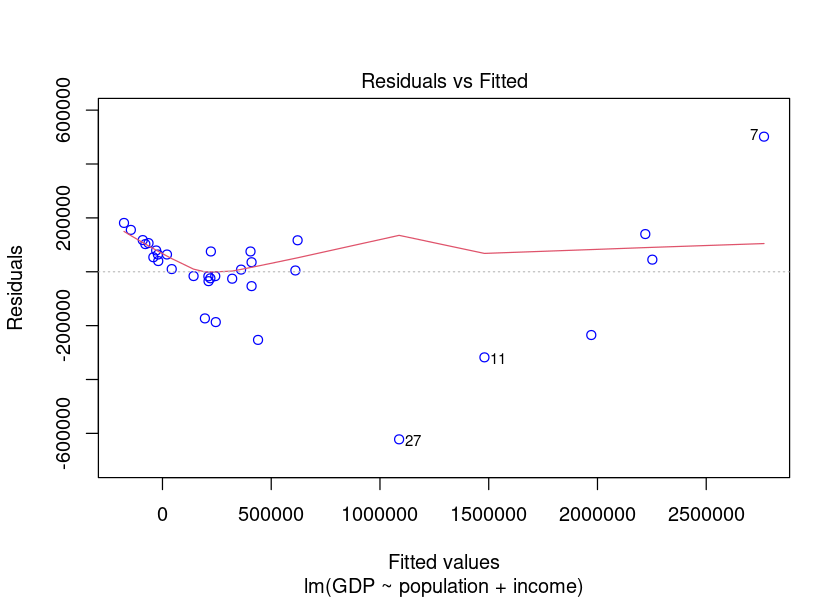

In [54]:
# korelace reziduí
plot(fit_lin_all_transform, which=1, col=c("blue"))

# test nekorelovanosti reziduí
dwtest(fit_lin_all_transform, alternative="two.sided")

3. odchylky jsou gaussovské.

Normalitu reziduí můžeme otestovat Kolmogorovým-Smirnovým testem normality, který je robustnější v případě outlierů oproti Shapiro-Wilkovu testu:

- $H_0$: $X_1,\ldots, X_n$ je výběr z normálního rozdělení
- $H_A$: neplatí $H_0$

Na základě p-hodnoty 0.0863 nezamítáme normalitu reziduí. Z Q-Q grafu bychom normalitu taktéž odhadovali.

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.8694         0.0009 
Kolmogorov-Smirnov        0.2128         0.0863 
Cramer-von Mises          3.1212         0.0000 
Anderson-Darling          1.6267         0.0003 
-----------------------------------------------

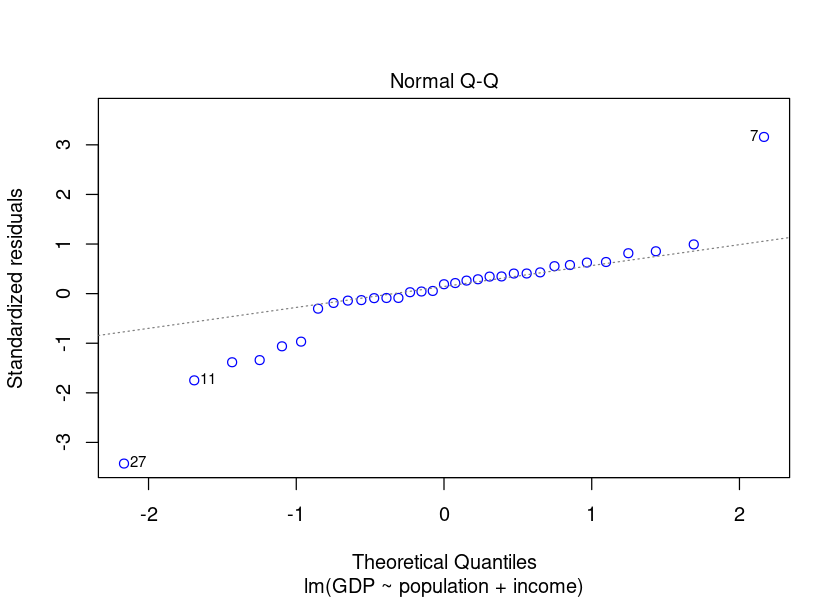

In [55]:
plot(fit_lin_all_transform, which=2, col=c("blue"))
ols_test_normality(fit_lin_all_transform)

#### Finální podmodel neobsahující nevýznamné kompomenty

Nový model neobsahuje statisticky nevýznamné komponenty. U interceptu, populace i příjmu zamítáme nulovost jejich koeficientu v modelu lineární regrese.

V porovnání s původním modelem je adjustovaný koeficient determinace oproti 94,8 mírně menší a to 94,5. F-test významnosti modelu opět zamítá nezávislost regresandu na regresorech.

In [56]:
summary(fit_lin_all_transform)


Call:
lm(formula = GDP ~ population + income, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-622183  -25769   35391   79008  501539 

Coefficients:
                  Estimate     Std. Error t value Pr(>|t|)    
(Intercept) -244699.995204   62924.033805  -3.889 0.000518 ***
population        0.033042       0.001504  21.975  < 2e-16 ***
income           11.445622       2.650686   4.318 0.000158 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 190600 on 30 degrees of freedom
Multiple R-squared:  0.9453,	Adjusted R-squared:  0.9417 
F-statistic: 259.5 on 2 and 30 DF,  p-value: < 2.2e-16


Během analýzy regresorů jsme narazili na nelineární souvislost mezi HDP, populací a příjmy. Stálo by za zvážení zkusit i varianty modelu s nelineárně transformovanými příznaky.

Vyzkoušíme lineární regresní model s jediným příznakem vzniklým jako součin populace a příjmu.

U nově vzniklého příznaku zamítáme nulovost koeficientu. Oproti předchozím modelům razantně snižuje chybu reziduí na hodnotu 66540.

Koeficient determinace je mnohem lepší a to 0.9929, což mluví ve prospěch modelu. 

F-test významnosti modelu opět zamítá nezávislost regresandu na regresorech.

In [57]:
fit_transformed1 <- lm(GDP ~ population * income, data=data)
predicts <- predict(fit_transformed1, interval="prediction")
df_fit_transformed1 <- cbind(data, predicts)
summary(fit_transformed1)

Warning message in predict.lm(fit_transformed1, interval = "prediction"):
“predictions on current data refer to _future_ responses
”



Call:
lm(formula = GDP ~ population * income, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-202799  -13505   -6753    9216  239870 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -3.420e+02  2.753e+04  -0.012    0.990    
population         3.665e-03  2.062e-03   1.778    0.086 .  
income             8.619e-01  1.172e+00   0.736    0.468    
population:income  1.322e-06  8.974e-08  14.733 5.33e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 66540 on 29 degrees of freedom
Multiple R-squared:  0.9936,	Adjusted R-squared:  0.9929 
F-statistic:  1491 on 3 and 29 DF,  p-value: < 2.2e-16


Nyní se podíváme na hodnoty Akaikeho informačního kritéria a Bayesovského informačního kritéria.

V Akaikeho kritériu si vede nový model mírně lépe, v Bayesovském kritériu je nový model přibližně stejný.

Nelineární model si vede v obou kritériích hůře.

In [58]:
# informační kritéria (AIC, BIC)
AIC(fit_lin_all, fit_lin_all_transform, fit_transformed1)
BIC(fit_lin_all, fit_lin_all_transform, fit_transformed1)

,df,AIC
,<dbl>,<dbl>
fit_lin_all,6,898.2820
fit_lin_all_transform,4,900.9172
fit_transformed1,5,832.3522


,df,BIC
,<dbl>,<dbl>
fit_lin_all,6,907.2611
fit_lin_all_transform,4,906.9033
fit_transformed1,5,839.8347


Otestujeme, zda je mezi modely statisticky významný rozdíl.

Na základě p-hodnoty 0.059 můžeme tvrdit, že mezi původním modelem a modelem bez korelovaných příznaků není statisticky významný rozdíl.

Oproti tomu je u modelu s nelineárním vztahem mezi příznaky statisticky významný rozdíl oproti původnímu modelu, a proto ho nebudeme využívat.

In [59]:
# porovnání modelů bez nevýznamné komponenty
anova(fit_lin_all, fit_lin_all_transform, fit_transformed1)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,28,891046191551,NA,NA,NA,NA
2,30,1089487550734,-2,-198441359184,3.117884,0.059908886497
3,29,128397142464,1,961090408270,30.201051,0.000007170493


Finální regresní model predikující HDP země je závislý na dvou příznacích - populaci a příjmu obyvatel. Koeficienty u příznaků nám říkají, jakým číslem máme vynásobit hodnotu daného příznaku v lineární kombinaci příznaků s přičteným interceptem.

Na následujících grafech si můžeme prohlédnout regresní křivku odhadující HDP a tečky jsou reálné hodnoty.

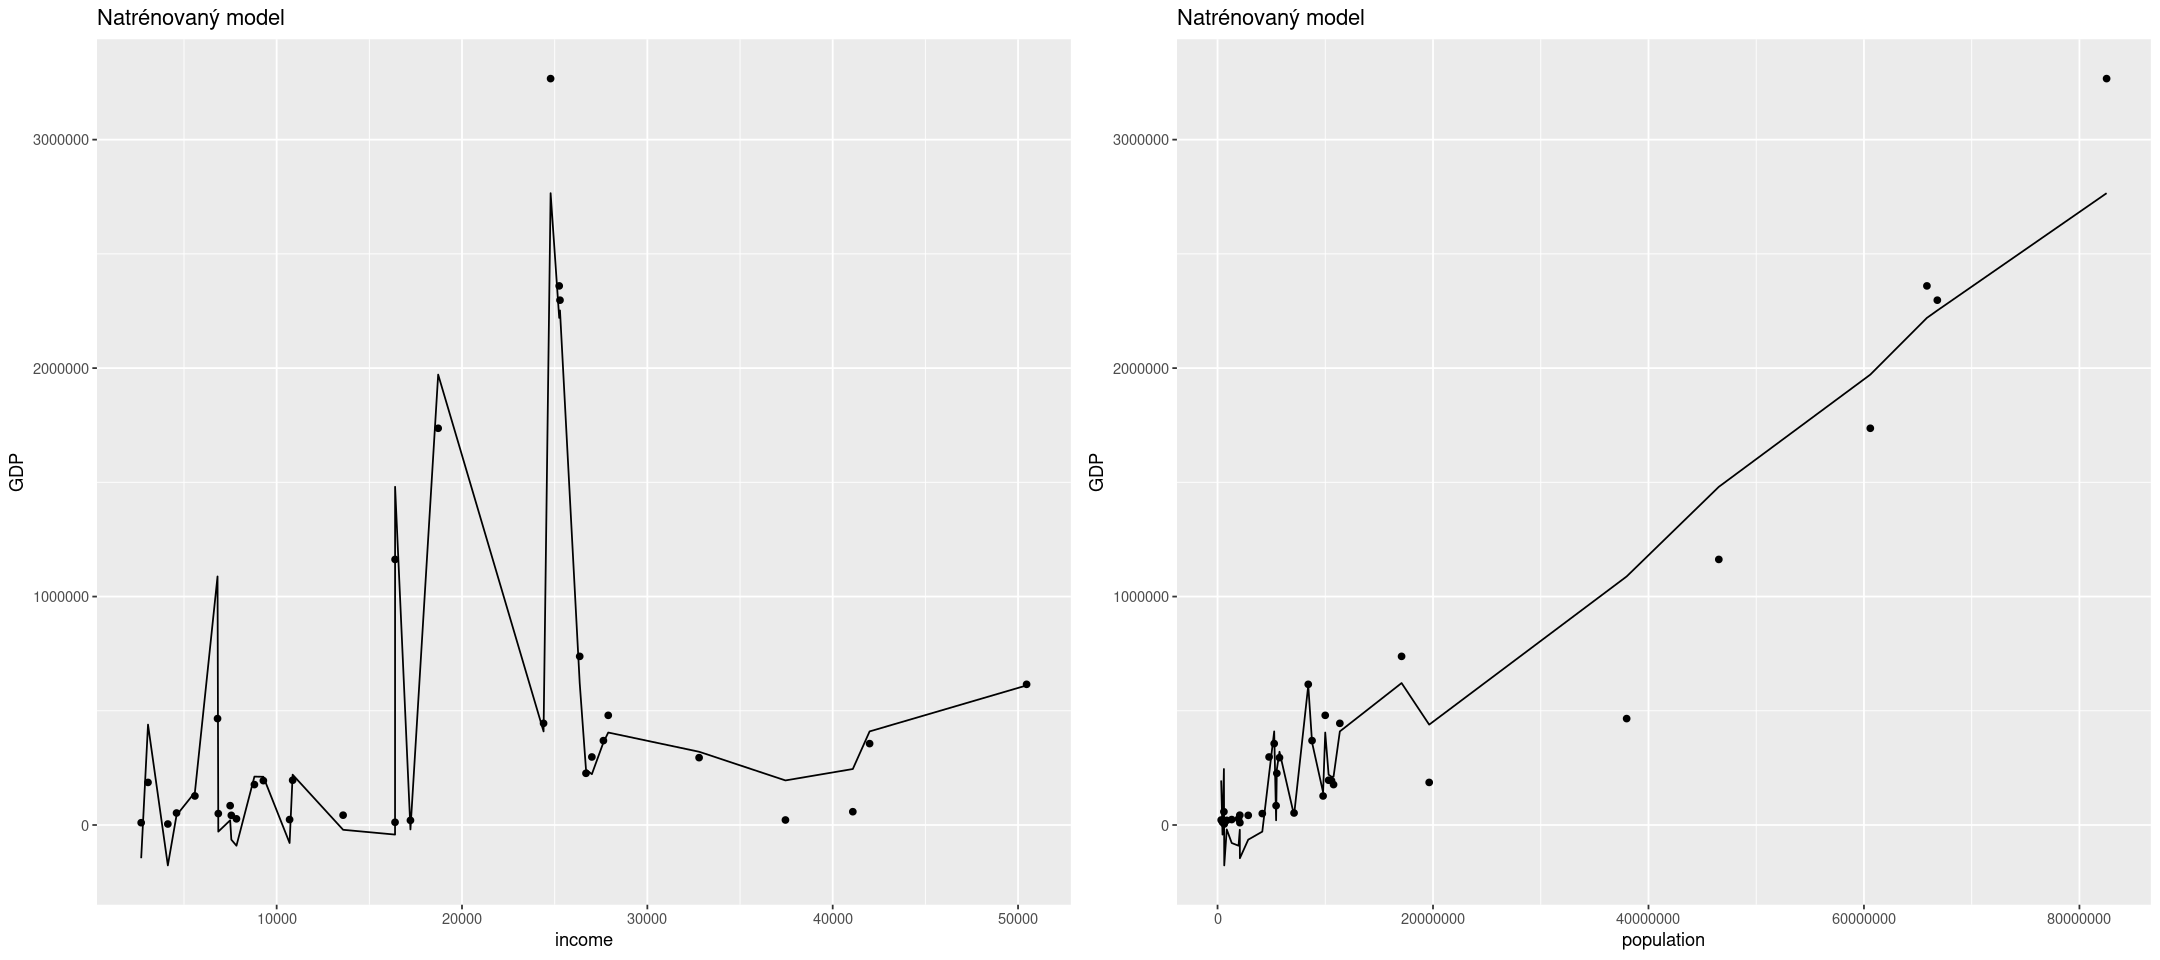

In [61]:
# regresní závislost graficky
options(repr.plot.width=18, repr.plot.height=8)
p1 <- ggplot(df_lin_all_transform, aes(x=income, y=GDP)) +
    geom_point() +
    geom_line(aes(y=fit)) +
    labs(title="Natrénovaný model")

p2 <- ggplot(df_lin_all_transform, aes(x=population, y=GDP)) +
    geom_point() +
    geom_line(aes(y=fit)) +
    labs(title="Natrénovaný model")

grid.arrange(p1, p2, nrow=1)